# Quantum Optimal Control for Two-Level Systems

**Author:** pmpoggi @ strath (February 2024)

This notebook uses GRAPE + BFGS to optimize unitaries for a two-level system. The implementation focuses on Landau-Zener transitions with optimal control fields.

## Import Required Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.linalg as alg
import scipy.optimize as optim

## General Functions and Definitions

Define the basic quantum mechanical operators and utility functions.

In [ ]:
# Dimension of Hilbert space
dim = 2

# Pauli matrices
X = np.array([[0, 1], [1, 0]], dtype=complex)
Y = np.array([[0, -1j], [1j, 0]], dtype=complex)
Z = np.array([[1, 0], [0, -1]], dtype=complex)
iden2 = np.identity(dim)


# Utility functions
def herm(A):
    """Return Hermitian conjugate of matrix A"""
    return np.conjugate(A.T)

## System Functions and Parameters

Define the Landau-Zener Hamiltonian and propagation functions.

In [ ]:
# System parameters
Delta = 1.0
T0 = np.pi / (2 * Delta)  # measure time in this unit


def HLZ(x):
    """Landau-Zener Hamiltonian: H = H0 + x*Hc"""
    return Delta * X + x * Z


# Control Hamiltonian
Hc = Z


def gen_propag(x):
    """Generate time evolution propagator for control field x"""
    Ut = np.empty([Nts + 1, dim, dim], dtype=complex)
    Ut[0, :, :] = np.identity(dim)

    for kt in range(Nts):
        Udt = alg.expm(-1j * HLZ(x[kt]) * dt)
        Ut[kt + 1] = np.dot(Udt, Ut[kt])

    return Ut

## Optimization and Evolution Parameters

In [ ]:
# Optimization parameters
method_gr = "L-BFGS-B"  # BFGS or L-BFGS-B
grad_tol = 1e-06  # tolerance for gradient
Nts = 10  # number of time-steps
Nattempts = 3  # number of random initializations

# Time evolution parameters
# Tfs = np.linspace(0.1, 2, 35)  # run like this for a fidelity vs T plot
Tfs = [2]  # run like this to see the actual fields
fide_opt = np.zeros(len(Tfs))
dt = 2/Nts
# Initial and target state parameters
nu0 = 2
theta0 = np.arctan(-Delta / nu0)
# theta0 = np.pi/4
thetaf = np.pi - theta0
psi0 = np.array([np.cos(theta0 / 2), np.sin(theta0 / 2)])
psiG = np.array([np.cos(thetaf / 2), np.sin(thetaf / 2)])

# Initial guess for the field
guess = "random"

## Optimization Functions

Define the cost function and its gradient for the GRAPE optimization.

In [ ]:
def Jcost(x):
    """Cost function: 1 - |<psiG|U(T)|psi0>|^2"""
    UT = gen_propag(x)[-1]
    z = np.vdot(psiG, np.dot(UT, psi0))
    cost_step = 1 - abs(z) ** 2
    return cost_step


def Jgrad(x):
    """Gradient of the cost function with respect to control fields"""
    Ut = gen_propag(x)
    z = np.vdot(psiG, np.dot(Ut[-1], psi0))

    # Compute gradient w/respect to fields
    gradi_fields = np.zeros(Nts)

    for kj in range(Nts):
        hj = HLZ(x[kj])

        # Eigendecomposition of Hamiltonian
        [vals, vecs] = alg.eigh(hj)
        dhj_daj = Hc

        # Transform derivative to Hamiltonian basis
        dhj_daj_rb = np.dot(herm(vecs), np.dot(dhj_daj, vecs))

        # Compute matrix elements of propagator derivative
        g_h_rb = np.zeros([dim, dim], dtype=complex)
        for n in range(dim):
            for m in range(dim):
                if abs(vals[m] - vals[n]) < 1e-4:
                    g_h_rb[n, m] = (
                        -1j * dt * dhj_daj_rb[n, m] * np.exp(-1j * dt * vals[n])
                    )
                else:
                    g_h_rb[n, m] = (
                        dhj_daj_rb[n, m]
                        * (np.exp(-1j * dt * vals[n]) - np.exp(-1j * dt * vals[m]))
                        / (vals[n] - vals[m])
                    )

        # Transform back to canonical basis
        g_h = np.dot(vecs, np.dot(g_h_rb, herm(vecs)))
        duj_daj = g_h

        # Compute full propagator derivative
        Ufw = Ut[kj]
        Ubw = np.dot(Ut[-1], herm(Ut[kj + 1]))
        dU_daj = np.dot(Ubw, np.dot(duj_daj, Ufw))

        # Compute gradient element
        dz_daj = np.vdot(psiG, np.dot(dU_daj, psi0))
        gradi_fields[kj] = -2 * np.real(dz_daj * np.conjugate(z))

    return gradi_fields

In [ ]:
# Test code
import numpy as np
from scipy.linalg import expm, expm_frechet


def d_expm_dx(H: np.ndarray, dHdx: np.ndarray, method: str = "block") -> np.ndarray:
    """
    Return d/dx expm(H(x)) given H and dHdx at the same x.

    method:
      - "block": uses expm([[H, dHdx],[0,H]]) and returns the upper-right block. [web:66]
      - "frechet": uses scipy.linalg.expm_frechet(H, dHdx). [web:82]
    """
    H = np.asarray(H)
    dHdx = np.asarray(dHdx)
    assert H.shape == dHdx.shape
    n = H.shape[0]
    assert H.shape == (n, n)

    if method == "block":
        Z = np.zeros_like(H)
        M = np.block([[H, dHdx], [Z, H]])
        EM = expm(M)
        return EM[:n, n:]  # this equals d/dx expm(H) [web:66]

    if method == "frechet":
        # Frechet derivative of exp at H applied to direction dHdx is exactly d/dx exp(H). [web:82]
        return expm_frechet(H, dHdx, compute_expm=False)

    raise ValueError("method must be 'block' or 'frechet'")


# Example usage:

H = np.array([[0.0, 1.0], [-2.0, 0.0]])
dHdx = np.array([[0.1, 0.0], [0.0, -0.2]])

dExp = d_expm_dx(H, dHdx, method="block")
print(dExp)

[[ 0.09697122 -0.0349228 ]
 [ 0.0698456  -0.11256558]]


In [ ]:
def Jgrad(x):
    """Gradient of the cost function with respect to control fields"""
    Ut = gen_propag(x)
    z = np.vdot(psiG, np.dot(Ut[-1], psi0))

    # Compute gradient w/respect to fields
    gradi_fields = np.zeros(Nts)

    for kj in range(Nts):
        hj = HLZ(x[kj])
        duj_daj = d_expm_dx(-1j * hj * dt, -1j * Hc * dt, method="block")

        # Compute full propagator derivative
        Ufw = Ut[kj]
        Ubw = np.dot(Ut[-1], herm(Ut[kj + 1]))
        dU_daj = np.dot(Ubw, np.dot(duj_daj, Ufw))

        # Compute gradient element
        dz_daj = np.vdot(psiG, np.dot(dU_daj, psi0))
        gradi_fields[kj] = -2 * np.real(dz_daj * np.conjugate(z))

    return gradi_fields

## Main Optimization Loop

Run the optimization for different evolution times and initial guesses.

In [ ]:
# Initialize timing and optimization variables
t_script_0 = time.time()
field_opt = 0

# Constraint parameters
const_crit = Delta**2 / nu0
c_const = (
    2  # constraint on the amplitude of the field. if set to 0, there is no constraint
)

# Storage for multiple attempts
fide_attempts = np.zeros([len(Tfs), Nattempts])

# Main optimization loop
for nA in range(Nattempts):
    for mT in range(len(Tfs))[::-1]:  # Start from longest time

        Tf = Tfs[mT] * T0
        t = np.linspace(0.0, Tf, Nts + 1)
        tfield = np.linspace(0.0, Tf, Nts)
        dt = t[1] - t[0]

        print("Run %d of %d, attempt %d of %d" % (mT + 1, len(Tfs), nA + 1, Nattempts))

        # Initialize field for first T value
        if mT == len(Tfs) - 1:
            if guess == "random":
                field_x0 = 2 * (np.random.rand(Nts) - 0.5)
            elif guess == "zero":
                field_x0 = np.zeros(Nts)
            cost_x0 = Jcost(field_x0)
        else:
            field_x0 = field_opt

        # Run optimization with or without constraints
        if c_const != 0:
            opt_result = optim.minimize(
                Jcost,
                x0=field_x0,
                method=method_gr,
                jac=Jgrad,
                bounds=optim.Bounds(lb=-c_const, ub=c_const),
                options={"gtol": grad_tol, "disp": False},
            )
        else:
            opt_result = optim.minimize(
                Jcost,
                x0=field_x0,
                method=method_gr,
                jac=Jgrad,
                options={"gtol": grad_tol, "disp": True},
            )

        # Store results
        field_opt = opt_result["x"]
        final_fide = opt_result["fun"]

        print(final_fide)
        fide_attempts[mT, nA] = final_fide

# For each value of T, pick the best fidelity out of all attempts
for mT in range(len(Tfs)):
    fide_opt[mT] = np.amin(fide_attempts[mT, :])

Run 1 of 1, attempt 1 of 3
0.0
Run 1 of 1, attempt 2 of 3
9.325873406851315e-15
Run 1 of 1, attempt 3 of 3
0.0


C:\Users\dev\AppData\Local\Temp\1\ipykernel_92540\313835808.py:37: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  opt_result = optim.minimize(


## Visualization and Results

Plot the optimization results - either the optimal fields or the fidelity vs time.

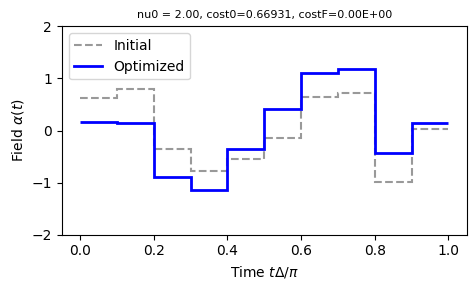

In [ ]:
# Plotting parameters
colore = ["tab:orange", "b"]
lab = ["zero", "random"]
ind = 1

# Plot optimal fields for single time evolution
if len(Tfs) == 1:
    plt.figure(1, figsize=(5, 3))
    plt.title("nu0 = %.2f, cost0=%.5f, costF=%.2E" % (nu0, cost_x0, final_fide), size=8)
    plt.stairs(
        field_x0,
        t / (2 * T0),
        baseline=None,
        linestyle="--",
        linewidth=1.5,
        color="0.6",
        label="Initial",
    )
    plt.stairs(
        field_opt,
        t / (2 * T0),
        baseline=None,
        linewidth=2,
        color=colore[ind],
        label="Optimized",
    )
    plt.ylim([-2, 2])
    plt.xlabel(r"Time $t\Delta/\pi$")
    plt.ylabel(r"Field $\alpha(t)$")
    plt.legend()
    plt.tight_layout()

    # Uncomment to save data and plots
    # np.savetxt("Data_Plots_QOC/Fig1-A/cost_values_nu0_%d_"%nu0+guess+".txt",[cost_x0,final_fide])
    # np.savetxt("Data_Plots_QOC/Fig1-A/Time.txt",t)
    # np.savetxt("Data_Plots_QOC/Fig1-A/field_ini_nu0_%d_"%nu0+guess+".txt",field_x0)
    # np.savetxt("Data_Plots_QOC/Fig1-A/field_opt_nu0_%d_"%nu0+guess+".txt",field_opt)
    # plt.savefig("plots/LZ_fields_nu0%d_alfa0_"%nu0+lab[ind]+".svg",dpi=300,bbox_inches='tight')

# Plot fidelity vs evolution time
if len(Tfs) > 1:
    plt.figure(1, figsize=(5, 3))
    plt.semilogy(Tfs, fide_opt, "o-", label="nu0=%.2f" % nu0)
    plt.xlabel(r"Evolution time $T/T_0$")
    plt.ylabel(r"Optimized cost $J(\alpha_{opt})$")
    plt.legend()
    plt.tight_layout()

    # Uncomment to save data
    # np.savetxt("data/LZ_final_cost_nu%.2f_const%d_M%d.txt"%(nu0,c_const,Nts),fide_opt)
    # np.savetxt("data/LZ_Tfs.txt",Tfs)

plt.show()